In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import altair
import seaborn
RANDOM_SEED = 511
rng = np.random.default_rng(RANDOM_SEED)
seaborn.set_theme(style="darkgrid")
altair.renderers.enable('mimetype')

db_url: str = os.getenv('DB_URL')

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from lib import wrap_labels, adjust_pairplot_axes

In [26]:
# OTP concentration by 

sql = """
select
    uhf_name || ' (' || borough_name || ')' AS Neighborhood,
    100 * coalesce(total_admissions_3_2019, 0) :: float / sum(total_admissions_3_2019) over () as "Opioid Treatment Admissions (2019)",
    100 * coalesce(overdose_deaths_2020, 0) :: float / sum(overdose_deaths_2020) over () as "Overdose Deaths (2020)",
    100 * coalesce(opioid_burden_2019, 0) :: float / sum(opioid_burden_2019) over () as "Opioid Burden (2019)",
    100 * coalesce(patient_admissions_3_2019, 0) :: float / sum(patient_admissions_3_2019) over () as "Patient Population (2019)",
    100 * population_2020_estimate :: float / sum(population_2020_estimate) over () as "Population (2020)"
from uhf_otp_analysis
order by 4 desc
limit 10
"""
uhf_od_df = pd.read_sql(sql, con=db_url)
uhf_od_df.head(3).T


,0,1,2
neighborhood,Crotona - Tremont (Bronx),High Bridge - Morrisania (Bronx),Fordham - Bronx Park (Bronx)
Opioid Treatment Admissions (2019),10.636136,6.08784,0.63301
Overdose Deaths (2020),6.711409,5.536913,5.145414
Opioid Burden (2019),7.232913,6.220969,5.383212
Patient Population (2019),7.668313,7.443029,4.87826
Population (2020),2.526588,2.565256,3.178876


''

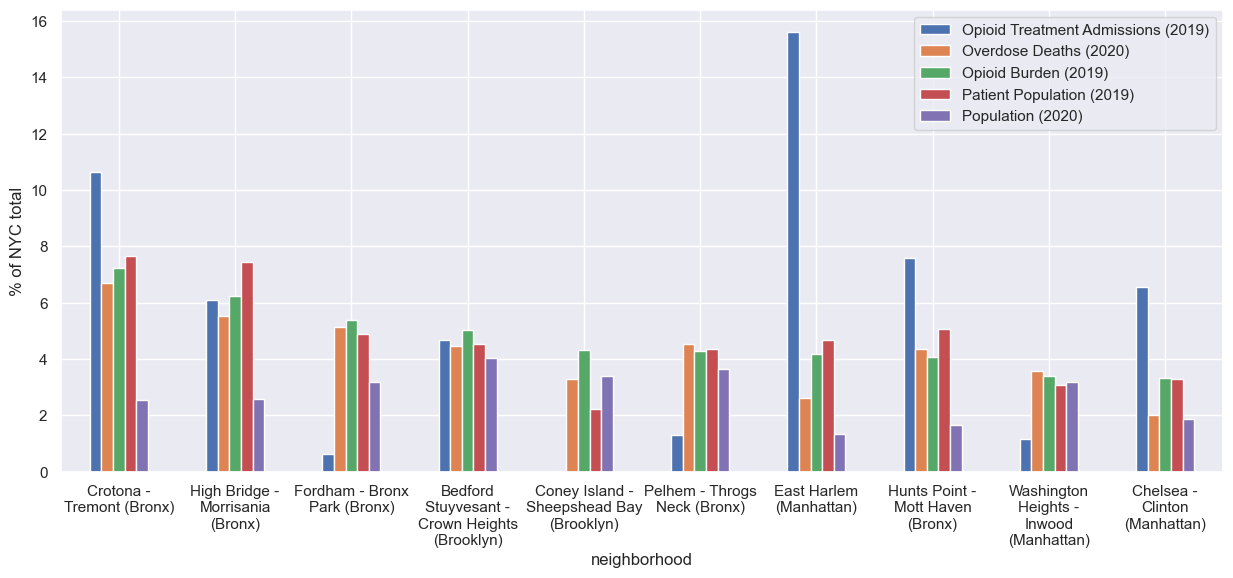

In [20]:
ax = uhf_od_df.plot(kind='bar', x='neighborhood', figsize=(15, 6), ylabel=r'% of NYC total')
wrap_labels(ax, 15)
;

In [60]:
sql = """
with by_zip as (
    SELECT
        is_harlem,
        borough_name,
        100 * sum(population_2020_estimate) :: float / sum(sum(population_2020_estimate)) over () as population_2020_estimate,
        100 * sum(total_admissions_3_2019) :: float / sum(sum(total_admissions_3_2019)) over () AS total_admissions_3_2019,
        100 * sum(otp_capacity) :: float / sum(sum(otp_capacity)) over () AS otp_capacity,
        100 * sum(avg_daily_enrollment_2019) :: float / sum(sum(avg_daily_enrollment_2019)) over () AS avg_daily_enrollment_2019,
        100 * sum(patient_admissions_3_2019) :: float / sum(sum(patient_admissions_3_2019)) over () AS patient_admissions_3_2019,
        100 * sum(opioid_burden_2019) :: float / sum(sum(opioid_burden_2019)) over () AS opioid_burden_2019
    FROM zip_code_otp_analysis
    GROUP BY 1, 2
), by_uhf as (
    SELECT
        is_harlem,
        borough_name,
        100 * sum(overdose_deaths_2020) :: float / sum(sum(overdose_deaths_2020)) over () as overdose_deaths_2020
    FROM uhf_otp_analysis
    GROUP BY 1, 2
)
, combined as (
    select
        --CASE WHEN borough_name = 'Manhattan' THEN 'Manhattan (incl. Harlem)' 
        --    ELSE borough_name END as borough_name,
        borough_name,
        --sum(total_admissions_3_2019) AS "OTP Admissions (2019)",
        sum(otp_capacity) AS "OTP Capacity (2019)",
        --sum(avg_daily_enrollment_2019) AS "OTP Daily Enrollment (2019)",
        --sum(patient_admissions_3_2019) AS "OTP Patient Population (2019)",
        --sum(opioid_burden_2019) AS "Opioid Burden (2019)",
        sum(overdose_deaths_2020) AS "Overdose Deaths (2020)",
        sum(population_2020_estimate) AS "Population (2020)"
    from by_zip
        full outer join by_uhf using (is_harlem, borough_name)
    -- where not is_harlem
    group by 1

    union

    select
        'Harlem Alone' AS borough_name,
        --sum(total_admissions_3_2019) AS "OTP Admissions (2019)",
        sum(otp_capacity) AS "OTP Capacity (2019)",
        --sum(avg_daily_enrollment_2019) AS "OTP Daily Enrollment (2019)",
        --sum(patient_admissions_3_2019) AS "OTP Patient Population (2019)",
        --sum(opioid_burden_2019) AS "Opioid Burden (2019)",
        sum(overdose_deaths_2020) AS "Overdose Deaths (2020)",
        sum(population_2020_estimate) AS "Population (2020)"
    from by_zip
        join by_uhf using (is_harlem, borough_name)
    where is_harlem
    group by 1
)
select * from combined order by "Overdose Deaths (2020)" desc
"""
borough_od_df = pd.read_sql(sql, con=db_url)
borough_od_df.head(3).T

,0,1,2
borough_name,Bronx,Brooklyn,Queens
OTP Capacity (2019),31.338006,21.434383,4.978409
Overdose Deaths (2020),29.9217,23.657718,20.0783
Population (2020),17.138887,30.8477,27.117191


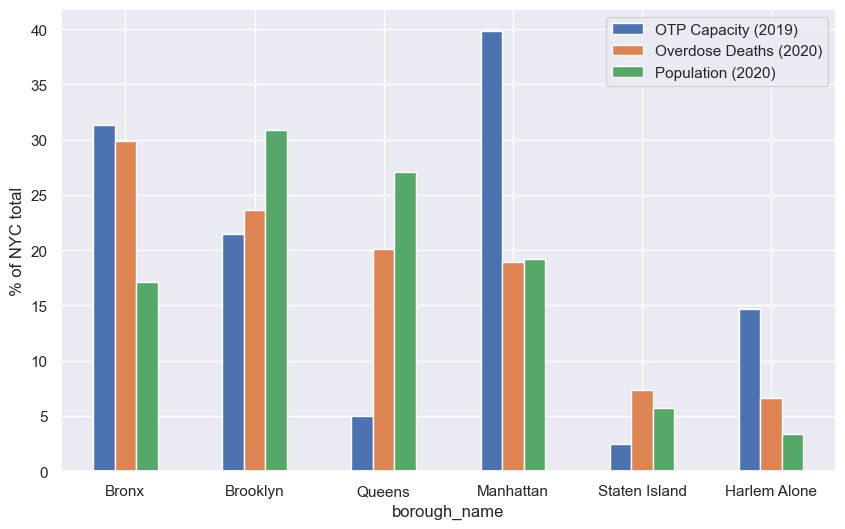

In [61]:
ax = borough_od_df.plot(kind='bar', x='borough_name', figsize=(10, 6), ylabel=r'% of NYC total')
wrap_labels(ax, 15)